In [294]:
import pandas as pd
import numpy as np
import tensorflow as tf  
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.metrics import mean_squared_error
import seaborn as sns

## Get data

In [295]:
df=pd.read_csv('TSLA.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-09-30,48.796001,47.222000,48.599998,48.174000,29399000.0,48.174000
1,2019-10-01,49.189999,47.826000,48.299999,48.938000,30813000.0,48.938000
2,2019-10-02,48.930000,47.886002,48.658001,48.625999,28157000.0,48.625999
3,2019-10-03,46.896000,44.855999,46.372002,46.605999,75422500.0,46.605999
4,2019-10-04,46.956001,45.613998,46.321999,46.285999,39975000.0,46.285999


In [296]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
High,639.0,5.433629e+02,3.408374e+02,4.689600e+01,1.702580e+02,6.204100e+02,7.965850e+02,1.243490e+03
Low,639.0,5.178835e+02,3.253959e+02,4.485600e+01,1.623800e+02,5.955000e+02,7.677450e+02,1.217000e+03
Open,639.0,5.310041e+02,3.335344e+02,4.596000e+01,1.673500e+02,6.038800e+02,7.794450e+02,1.234410e+03
Close,639.0,5.312980e+02,3.333620e+02,4.628600e+01,1.647830e+02,6.051300e+02,7.813050e+02,1.229910e+03
Volume,639.0,4.819130e+07,3.579030e+07,9.800600e+06,2.392195e+07,3.448900e+07,6.329725e+07,3.046940e+08
Adj Close,639.0,5.312980e+02,3.333620e+02,4.628600e+01,1.647830e+02,6.051300e+02,7.813050e+02,1.229910e+03


In [297]:
df.set_index('Date',inplace = True)
df.index =  pd.to_datetime(df.index,format='%Y-%m-%d')

Text(0.5, 1.0, 'TESLA Stock at all time')

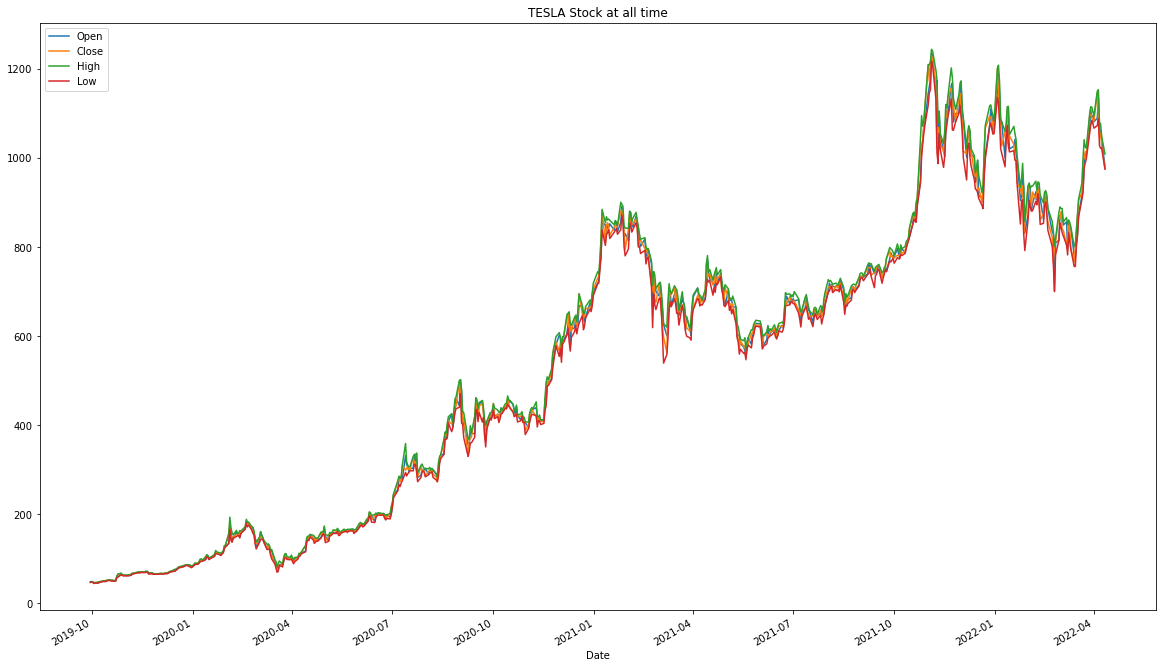

In [298]:
df[['Open','Close','High','Low']].plot(figsize = (20,12))
plt.title('TESLA Stock at all time')

In [299]:
train_df = df['High'].iloc[:-4]
# Take ramdom  6 variables 

X_train=[]
y_train=[]

for i in range(2, len(train_df)):
    X_train.append(train_df[i-2:i])
    y_train.append(train_df[i])
X_train, y_train= np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [300]:
import math
train_len = math.ceil(len(train_df)*0.8)
test_data = train_df[train_len-2:]
X_val=[]
Y_val=[] 

for i in range(2, len(test_data)):
    X_val.append(test_data[i-2:i])
    Y_val.append(test_data[i])
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

## Baseline sequential model by JILLANI SOFT TECH (LSTM)

### Kaggle notebook link: https://www.kaggle.com/code/jillanisofttech/tesla-stock-price-predication-using-lstm-and-rnn

In [301]:
model=Sequential()
model.add(LSTM(50,activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=2)

Epoch 1/10
7/7 - 1s - loss: 504022.5938
Epoch 2/10
7/7 - 0s - loss: 405853.4062
Epoch 3/10
7/7 - 0s - loss: 339439.6250
Epoch 4/10
7/7 - 0s - loss: 274082.4375
Epoch 5/10
7/7 - 0s - loss: 203351.1562
Epoch 6/10
7/7 - 0s - loss: 119075.0469
Epoch 7/10
7/7 - 0s - loss: 19961.9863
Epoch 8/10
7/7 - 0s - loss: 2386.9197
Epoch 9/10
7/7 - 0s - loss: 1538.6722
Epoch 10/10
7/7 - 0s - loss: 918.9830


<AxesSubplot:>

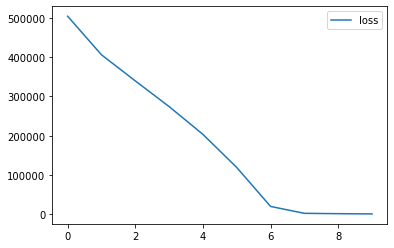

In [302]:
losse = pd.DataFrame(model.history.history)
losse[['loss']].plot()

In [303]:
prediction = model.predict(X_val)
# Know the model error accuracy | the model accuracy 
lstm_train_pred = model.predict(X_train)[:, 0]
lstm_valid_pred = model.predict(X_val)[:, 0]
train_rmse_1 = np.sqrt(mean_squared_error(y_train, lstm_train_pred))
val_rmse_1 = np.sqrt(mean_squared_error(Y_val, lstm_valid_pred))
print('Train rmse:', train_rmse_1)
print('Validation rmse:', val_rmse_1)

Train rmse: 25.521397
Validation rmse: 43.7455


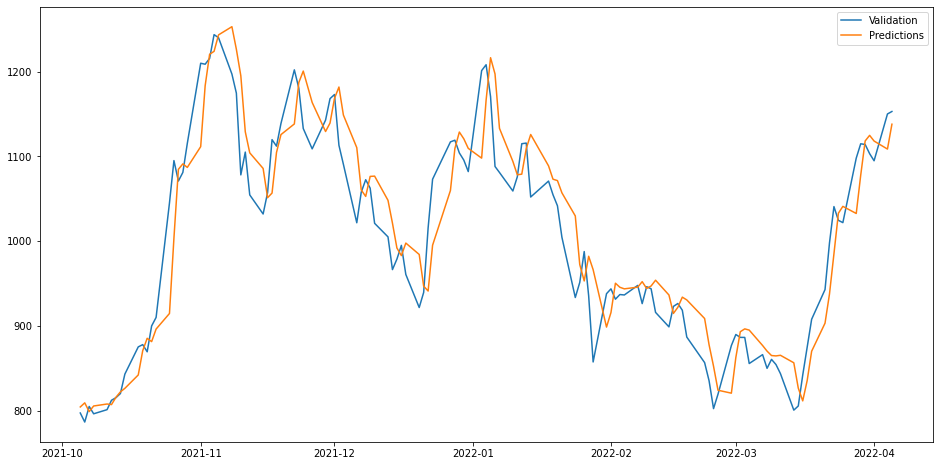

In [304]:
valid = pd.DataFrame(train_df[train_len:])
valid['Predictions']=lstm_valid_pred 
plt.figure(figsize=(16,8))
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

## Improved model using LSTM and attention

In [305]:
class DeltaSkipper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # Each tie step adds a delta calculated by the model to skip connections and improve memory
        return inputs + delta

In [306]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                            initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                            initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        alpha = K.softmax(e, axis=1)
        context = x*alpha
        # e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        # e = K.squeeze(e, axis=-1)   
        # Compute the weights
        # alpha = K.softmax(e)
        # Reshape to tensorFlow format
        # alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        # context = x * alpha
        # context = K.sum(context, axis=1)
        return context

In [307]:
def build_model(n_features):
    base_model = Sequential()
    base_model.add(tf.keras.layers.LSTM(50, return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
    base_model.add(attention())
    base_model.add(Dense(25))
    base_model.add(Dense(n_features, trainable=True, activation='tanh', kernel_initializer=tf.initializers.zeros()))
    
    model = DeltaSkipper(base_model) # initialize with a "base model"
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    return model  

In [308]:
model = build_model(1)

In [309]:
def fit_model(X_train, y_train, X_val, y_val, model, patience):
    MAX_EPOCHS = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')
    history = model.fit(X_train, y_train, epochs=MAX_EPOCHS,
                        callbacks=[early_stopping])
    train_mse_attn = model.evaluate(X_train, y_train)
    test_mse_attn = model.evaluate(X_val, y_val)
    print("Train MSE evaluation: {}".format(train_mse_attn))
    print("Test MSE evaluation: {}".format(test_mse_attn))
    return history, model, train_mse_attn, test_mse_attn

In [310]:
history, model, train_mse_2, val_mse_2 = fit_model(X_train, y_train, X_val, Y_val, model, 15)

Epoch 1/50
20/20 [==============================] - 1s 7ms/step - loss: 812.1682 - mean_absolute_error: 18.0453
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 809.1019 - mean_absolute_error: 18.0333
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 808.3722 - mean_absolute_error: 18.0253
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 808.1837 - mean_absolute_error: 18.0208
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 808.1075 - mean_absolute_error: 18.0189
Epoch 6/50
20/20 [==============================] - 0s 7ms/step - loss: 808.0660 - mean_absolute_error: 18.0190
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 808.0228 - mean_absolute_error: 18.0182
Epoch 8/50
20/20 [==============================] - 0s 7ms/step - loss: 808.0040 - mean_absolute_error: 18.0179
Epoch 9/50
20/20 [==============================] - 0s 9ms/step - loss: 807.9839 - mean_absolute_error: 

<AxesSubplot:>

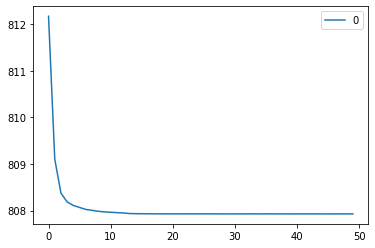

In [311]:
pd.DataFrame(history.history["loss"]).plot()

In [312]:
lstm_train_pred = model.predict(X_train)[:, 0, 0]
lstm_valid_pred = model.predict(X_val)[:, 0, 0]

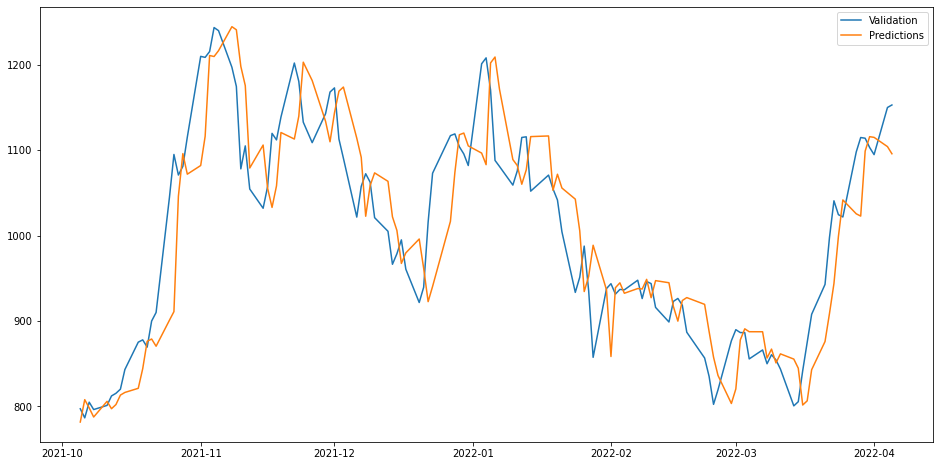

In [313]:
valid = pd.DataFrame(train_df[train_len:])
valid['Predictions']=lstm_valid_pred 
plt.figure(figsize=(16,8))
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

In [318]:
# Net gain of increasing complexity with attention
net_train_gain_rmse = np.sqrt(train_mse_2)[0] - train_rmse_1
net_val_gain_rmse = np.sqrt(val_mse_2)[0] - val_rmse_1
print("Net training RMSE reduction: {}".format(net_train_gain_rmse))
print("Net validation RMSE reduction: {}".format(net_val_gain_rmse))
print("Is it worth the complexity?: {}".format("Yes" if net_train_gain_rmse > 0 and net_val_gain_rmse > 0 else "No"))

Net training RMSE reduction: 2.9026568890150024
Net validation RMSE reduction: 5.322872806731766
Is it worth the complexity?: Yes
